# ライブラリのインポート

In [1]:
# データ探索のためのライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import japanize_matplotlib
from datetime import timedelta
import datetime

# 各種設定
warnings.simplefilter('ignore')
pd.options.display.max_rows=1000
pd.options.display.max_columns=300
pd.options.display.float_format = '{:.2f}'.format

# データの読み込み
- 使用するデータファイルは以下の5つ
1. station.csv: 各サイクルステーションで1時間ごとに記録された利用可能な自転車数（目的変数）の履歴データ
2. status.csv: 利用者がシェアサイクルで移動した時間、起点駅、終点駅等を記録した移動履歴データです。
3. trip.csv: サイクルステーションの緯度・経度、ドック数（最大で停められる自転車数）、設置日のデータ
4. weather.csv: 都市中心部における1日ごとの気象予報データ(0時時点)

In [2]:
station = pd.read_csv('station.csv', parse_dates=['installation_date'])
status = pd.read_csv('status.csv')
trip = pd.read_csv('trip.csv')
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
weather = pd.read_csv('weather.csv', parse_dates=['date'])

# 探索的データ分析
- 各データファイルに対してEDAを行う。主に行うことは以下の通り
- データの形状や欠損値の確認
- 一変量解析
- 二変量解析
- 可視化

## Status
- 利用可能台数(目的変数)と時間情報、ステーションid等があり欠損値はなし(利用可能台数が欠損となっているレコードは予測対象)
- 2013/9/1~2015/8/31のデータ
- 予測対象は2014/9/1以降
- 2013/9/1~2014/8/31はすべて予測対象ではないため、学習データとしてモデル構築に用いる
- 2014/9/1~2015/8/31のうち予測対象でないものを検証用データとして用いる
- 空き台数は徐々に減っていっている(≒効率的になっている)傾向にある
- 時間帯別の空き台数に関して全体的には日中が少なく早朝と深夜は多い傾向にあるが、ステーションによって異なる(ピークが日中or夜間)

In [3]:
display(status.head())
print(len(status))

,id,year,month,day,hour,station_id,bikes_available,predict
0,0,2013,9,1,0,0,11.00,0
1,1,2013,9,1,1,0,11.00,0
2,2,2013,9,1,2,0,11.00,0
3,3,2013,9,1,3,0,11.00,0
4,4,2013,9,1,4,0,11.00,0


1226400


In [4]:
status.isnull().sum()

id                      0
year                    0
month                   0
day                     0
hour                    0
station_id              0
bikes_available    416405
predict                 0
dtype: int64

In [5]:
status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226400 entries, 0 to 1226399
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1226400 non-null  int64  
 1   year             1226400 non-null  int64  
 2   month            1226400 non-null  int64  
 3   day              1226400 non-null  int64  
 4   hour             1226400 non-null  int64  
 5   station_id       1226400 non-null  int64  
 6   bikes_available  809995 non-null   float64
 7   predict          1226400 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 74.9 MB


In [6]:
# datetime型変数を作成
status['date'] = status['year'].astype(str) + status['month'].astype(str).str.zfill(2) + status['day'].astype(str).str.zfill(2)
status['date'] = pd.to_datetime(status['date'])
status_start = status['date'].min()
status_end = status['date'].max()
train_status = status.loc[status['predict']==0]
pred_status = status.loc[status['predict']==1]
train_status_start = train_status['date'].min()
train_status_end = train_status['date'].max()
pred_status_start = pred_status['date'].min()
pred_status_end = pred_status['date'].max()

print(f'開始: {status_start}')
print(f'終了: {status_end}')
print(f'学習期間開始: {train_status_start}')
print(f'学習期間終了: {train_status_end}')
print(f'予測期間開始: {pred_status_start}')
print(f'予測期間終了: {pred_status_end}')

開始: 2013-09-01 00:00:00
終了: 2015-08-31 00:00:00
学習期間開始: 2013-09-01 00:00:00
学習期間終了: 2015-08-31 00:00:00
予測期間開始: 2014-09-01 00:00:00
予測期間終了: 2015-08-29 00:00:00


In [7]:
# 2014/9/1以降のデータを抽出
tmp_df = status.loc[status['date'] >= '2014-09-01']
print(len(tmp_df.loc[tmp_df['predict']==0]))
print(len(tmp_df.loc[tmp_df['predict']==1]))

420000
193200


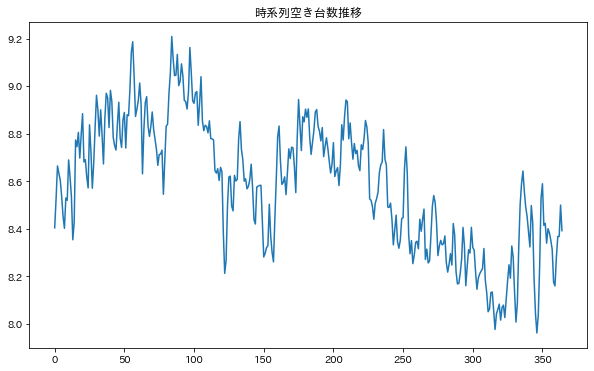

In [8]:
# 時系列で今までの推移を確認
tmp_df = status.loc[status['date'] < '2014-09-01']
bikes_data = tmp_df.groupby(['year', 'month', 'day'])['bikes_available'].mean()
plt.figure(figsize=(10, 6))
plt.plot(bikes_data.values)
plt.title('時系列空き台数推移')
plt.show()

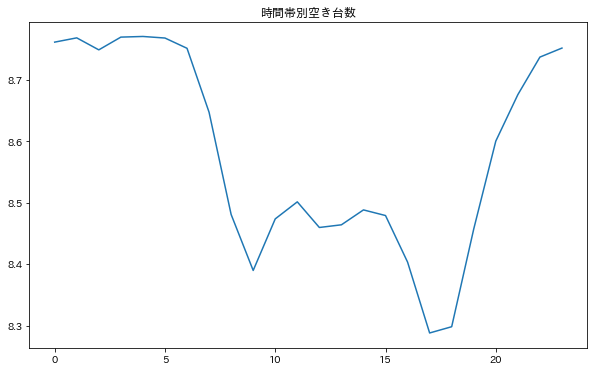

In [9]:
# 時間帯別に空き台数を確認
bikes_data_hour = tmp_df.groupby('hour')['bikes_available'].mean()
plt.figure(figsize=(10, 6))
plt.plot(bikes_data_hour.index, bikes_data_hour.values)
plt.title('時間帯別空き台数')
plt.show()

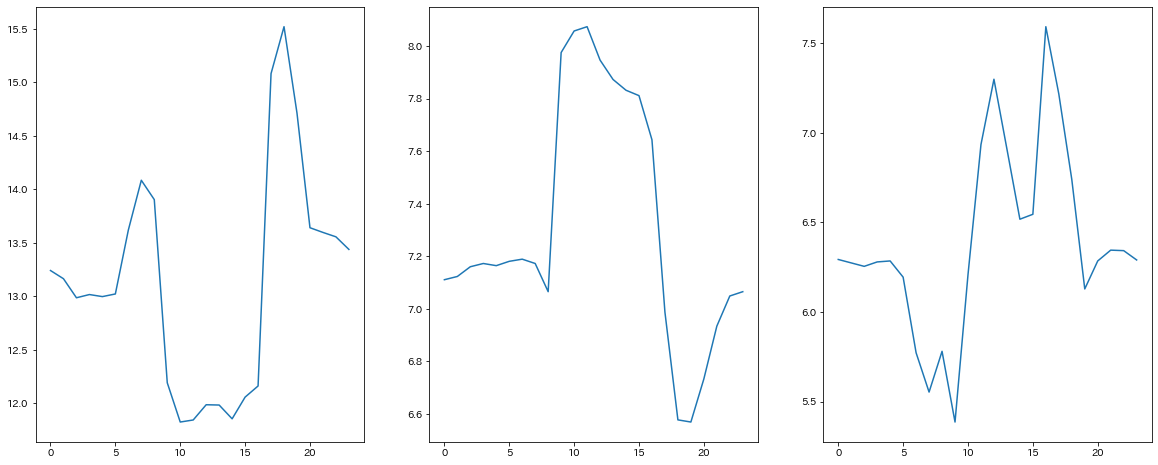

In [10]:
# ステーションをいくつか取り出し時間帯別の空き台数を確認
station_0 = tmp_df.loc[tmp_df['station_id']==0]
station_24 = tmp_df.loc[tmp_df['station_id']==24]
station_50 = tmp_df.loc[tmp_df['station_id']==50]
bikes_data_hour_0 = station_0.groupby('hour')['bikes_available'].mean()
bikes_data_hour_24 = station_24.groupby('hour')['bikes_available'].mean()
bikes_data_hour_50 = station_50.groupby('hour')['bikes_available'].mean()
plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.plot(bikes_data_hour_0.index, bikes_data_hour_0.values)
plt.subplot(132)
plt.plot(bikes_data_hour_24.index, bikes_data_hour_24.values)
plt.subplot(133)
plt.plot(bikes_data_hour_50.index, bikes_data_hour_50.values)
plt.show()

## Station
- 全70ステーションの位置情報、設置されている都市、導入日、ドック数(最大で停められる自転車数)が格納されている
- 欠損値はなし
- 都市はcity1~city5までの5種類, ドック数は27,15,11,19,25,23の6パターン
- 最も古いステーションは2013/8/5設置、最も新しいステーションは2014/4/9設置
- 6個のステーションを除いて2013年8月に設置されている

In [11]:
display(station.head())
print(len(station))

,station_id,lat,long,dock_count,city,installation_date
0,0,37.33,-121.90,27,city1,2013-08-06
1,1,37.33,-121.89,15,city1,2013-08-05
2,2,37.33,-121.89,11,city1,2013-08-06
3,3,37.33,-121.89,19,city1,2013-08-05
4,4,37.34,-121.89,15,city1,2013-08-07


70


In [12]:
station.isnull().sum()

station_id           0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [13]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   station_id         70 non-null     int64         
 1   lat                70 non-null     float64       
 2   long               70 non-null     float64       
 3   dock_count         70 non-null     int64         
 4   city               70 non-null     object        
 5   installation_date  70 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 3.4+ KB


In [14]:
station.nunique()

station_id           70
lat                  69
long                 70
dock_count            6
city                  5
installation_date    17
dtype: int64

In [15]:
print(station['city'].unique())
print(station['dock_count'].unique())

['city1' 'city3' 'city4' 'city5' 'city2']
[27 15 11 19 25 23]


In [16]:
station.groupby('city')['dock_count'].value_counts()

city   dock_count
city1  15            10
       19             4
       11             1
       27             1
city2  19            14
       15            12
       23             6
       27             3
city3  15             6
       25             1
city4  15             4
       23             2
       11             1
city5  11             2
       15             2
       23             1
Name: dock_count, dtype: int64

In [17]:
print(station['installation_date'].min())
print(station['installation_date'].max())

2013-08-05 00:00:00
2014-04-09 00:00:00


In [18]:
station.sort_values('installation_date')

,station_id,lat,long,dock_count,city,installation_date
1,1,37.33,-121.89,15,city1,2013-08-05
12,12,37.33,-121.90,19,city1,2013-08-05
3,3,37.33,-121.89,19,city1,2013-08-05
6,6,37.33,-121.89,15,city1,2013-08-05
7,7,37.35,-121.89,15,city1,2013-08-05
0,0,37.33,-121.90,27,city1,2013-08-06
9,9,37.34,-121.89,19,city1,2013-08-06
8,8,37.34,-121.89,15,city1,2013-08-06
11,11,37.34,-121.89,15,city1,2013-08-06
2,2,37.33,-121.89,11,city1,2013-08-06


## Trip
- 利用時間、利用開始時間、利用開始ステーション、利用終了時間、利用終了ステーション、自転車ID、サブスクリプションの種類が格納されている
- 欠損値はなし
- 期間はStatusと同じ
- 自転車は700種類で自転車ごとに利用回数に差がある
- サブスクリプションは2種類(定額プラン、一時利用)で比率は約5:1
- 一時利用者のほうが定額プラン利用者よりも平均利用時間が長い(それぞれ3952分、590分)
- 9割以上のケースで貸出ステーションと返却ステーションが異なる
- 貸出ステーションと返却ステーションが異なる場合のほうが利用時間が短い
- 貸出ステーションと返却ステーションが同じケースでは一時利用者が多い

In [19]:
display(trip.head())
print(len(trip))

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type
0,0,63,2013-08-29 14:13:00,54,2013-08-29 14:14:00,54,0,Subscriber
1,1,70,2013-08-29 14:42:00,8,2013-08-29 14:43:00,8,1,Subscriber
2,2,71,2013-08-29 10:16:00,20,2013-08-29 10:17:00,20,2,Subscriber
3,3,77,2013-08-29 11:29:00,8,2013-08-29 11:30:00,8,3,Subscriber
4,4,83,2013-08-29 12:02:00,54,2013-08-29 12:04:00,55,4,Subscriber


669959


In [20]:
print(trip['start_date'].min())
print(trip['start_date'].max())

2013-08-29 09:08:00
2015-08-31 23:26:00


In [21]:
trip.isnull().sum()

trip_id              0
duration             0
start_date           0
start_station_id     0
end_date             0
end_station_id       0
bike_id              0
subscription_type    0
dtype: int64

In [22]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            669959 non-null  int64         
 1   duration           669959 non-null  int64         
 2   start_date         669959 non-null  datetime64[ns]
 3   start_station_id   669959 non-null  int64         
 4   end_date           669959 non-null  datetime64[ns]
 5   end_station_id     669959 non-null  int64         
 6   bike_id            669959 non-null  int64         
 7   subscription_type  669959 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 40.9+ MB


In [23]:
print(trip['start_date'].min())
print(trip['start_date'].max())

2013-08-29 09:08:00
2015-08-31 23:26:00


In [24]:
trip.nunique()

trip_id              669959
duration              16129
start_date           361559
start_station_id         70
end_date             357757
end_station_id           70
bike_id                 700
subscription_type         2
dtype: int64

In [25]:
trip.describe()

,trip_id,duration,start_station_id,end_station_id,bike_id
count,669959.00,669959.00,669959.00,669959.00,669959.00
mean,334979.00,1107.95,47.14,47.18,281.98
std,193400.65,22255.44,14.67,14.73,186.50
min,0.00,60.00,0.00,0.00,0.00
25%,167489.50,344.00,40.00,39.00,127.00
50%,334979.00,517.00,50.00,50.00,254.00
75%,502468.50,755.00,58.00,58.00,421.00
max,669958.00,17270400.00,69.00,69.00,699.00


In [26]:
trip['bike_id'].value_counts()

251    2061
63     1975
185    1955
28     1951
83     1948
290    1942
545    1933
160    1932
216    1927
10     1926
217    1926
118    1922
126    1921
171    1915
100    1911
13     1909
45     1908
265    1906
32     1904
585    1904
325    1900
620    1899
534    1899
441    1893
357    1888
196    1885
245    1885
93     1878
165    1871
431    1869
50     1867
208    1860
116    1859
376    1859
361    1858
418    1855
19     1854
38     1854
454    1853
92     1852
158    1852
140    1850
365    1843
223    1842
159    1841
23     1840
542    1838
178    1838
518    1836
264    1833
65     1833
106    1830
300    1830
57     1829
232    1828
122    1826
197    1825
53     1821
42     1821
236    1821
302    1820
220    1819
0      1818
257    1818
16     1817
481    1816
259    1815
255    1815
80     1814
78     1814
483    1813
252    1812
348    1808
621    1807
157    1807
562    1805
378    1805
66     1803
473    1801
309    1801
384    1801
54     1799
137    1798
363 

In [27]:
trip['subscription_type'].value_counts()

Subscriber    566746
Customer      103213
Name: subscription_type, dtype: int64

In [28]:
trip.groupby('subscription_type')['duration'].mean()

subscription_type
Customer     3951.76
Subscriber    590.05
Name: duration, dtype: float64

In [29]:
trip.groupby('bike_id')['duration'].mean().sort_values(ascending=False)

bike_id
149   14014.83
294   10790.06
613    7331.31
350    6626.04
636    6506.13
104    5796.14
625    5236.61
474    5109.43
491    5105.34
655    5077.43
624    4554.67
626    4493.58
495    4442.89
436    4306.47
660    4244.09
299    4229.69
271    4110.49
372    3906.76
432    3822.78
321    3744.29
228    3698.39
162    3640.36
368    3516.99
263    3440.65
349    3362.87
403    3273.80
647    3246.95
673    3219.56
581    3201.79
183    3152.84
572    3100.98
682    3090.86
583    3084.22
522    3082.86
161    2991.72
668    2991.11
676    2947.12
202    2927.38
40     2915.21
539    2855.46
345    2825.54
588    2824.43
367    2817.87
669    2812.30
580    2800.31
337    2794.72
343    2773.24
557    2769.64
1      2740.86
422    2699.82
670    2663.72
437    2650.91
2      2645.62
639    2620.08
248    2610.00
462    2597.12
648    2576.61
313    2569.73
175    2546.54
407    2545.68
527    2524.39
679    2476.40
603    2470.09
569    2469.67
215    2468.34
242    2428.86
25

In [30]:
# 貸出ステーションと返却ステーションに着目
tmp_df_1 = trip.loc[trip['start_station_id']==trip['end_station_id']]
tmp_df_2 = trip.loc[trip['start_station_id']!=trip['end_station_id']]
print(f'貸出ステーションと返却ステーションが同じ: {len(tmp_df_1)} 件')
print(f'貸出ステーションと返却ステーションが異なる: {len(tmp_df_2)} 件')

貸出ステーションと返却ステーションが同じ: 23981 件
貸出ステーションと返却ステーションが異なる: 645978 件


In [31]:
print(tmp_df_1['duration'].mean())
print(tmp_df_2['duration'].mean())

6357.401109211459
913.0715519723582


In [32]:
print(tmp_df_1['subscription_type'].value_counts())
print(tmp_df_2['subscription_type'].value_counts())

Customer      16443
Subscriber     7538
Name: subscription_type, dtype: int64
Subscriber    559208
Customer       86770
Name: subscription_type, dtype: int64


## Weather
- 降雨量や風速など様々な天候データが格納されている
- eventsカラムには雨か霧の場合のみ値が格納されている

In [33]:
display(weather.head())
print(len(weather))

,date,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,events,wind_dir_degrees
0,2013-09-01,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354
1,2013-09-02,80,71,66,64,61,58,80,70,58,29.95,29.95,29.86,10,10,10,14,4,0.00,5,NaN,337
2,2013-09-03,81,69,58,60,56,52,82,65,44,29.99,29.99,29.93,10,10,10,19,2,1.71,6,Rain,341
3,2013-09-04,82,68,56,61,55,49,81,64,43,30.04,30.02,29.94,10,10,10,15,0,0.00,0,NaN,324
4,2013-09-05,81,68,56,59,54,50,81,63,41,30.02,30.02,29.95,10,10,10,16,1,0.00,0,NaN,335


730


In [34]:
weather.isnull().sum()

date                         0
max_temperature              0
mean_temperature             0
min_temperature              0
max_dew_point                0
mean_dew_point               0
min_dew_point                0
max_humidity                 0
mean_humidity                0
min_humidity                 0
max_sea_level_pressure       0
mean_sea_level_pressure      0
min_sea_level_pressure       0
max_visibility               0
mean_visibility              0
min_visibility               0
max_wind_Speed               0
mean_wind_speed              0
precipitation                0
cloud_cover                  0
events                     636
wind_dir_degrees             0
dtype: int64

In [35]:
weather['events'].value_counts()

Rain        82
Fog         10
Fog-Rain     2
Name: events, dtype: int64

In [36]:
print(weather['date'].max())
print(weather['date'].min())

2015-08-31 00:00:00
2013-09-01 00:00:00


## Status & Station
- 学習期間のStatusとStationをidで結合
- 空車率は時間帯や都市、曜日によって変わらないがステーションによっては異なる(例: station58は日中に使用率が高い)

In [37]:
merge_df = pd.merge(tmp_df, station, on='station_id', how='left')
display(merge_df.head())
print(len(merge_df))

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,city,installation_date
0,0,2013,9,1,0,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06
1,1,2013,9,1,1,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06
2,2,2013,9,1,2,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06
3,3,2013,9,1,3,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06
4,4,2013,9,1,4,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06


613200


In [38]:
# 空き率を算出する
merge_df['available_rate'] = merge_df['bikes_available'] / merge_df['dock_count']

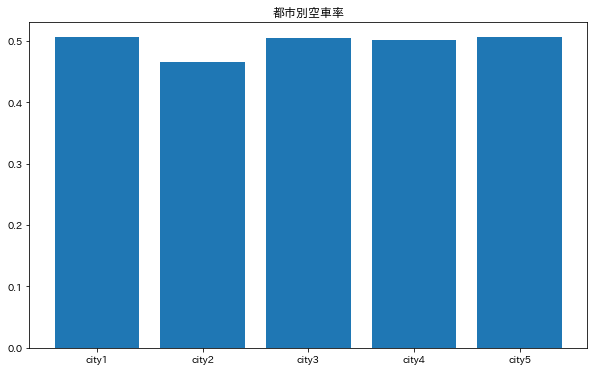

In [39]:
available_rate_by_city = merge_df.groupby('city')['available_rate'].mean()
plt.figure(figsize=(10, 6))
plt.bar(available_rate_by_city.index, available_rate_by_city.values)
plt.title('都市別空車率')
plt.show()

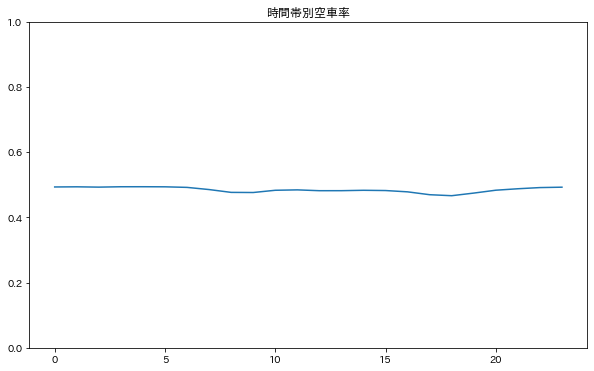

In [40]:
available_rate_by_hour = merge_df.groupby('hour')['available_rate'].mean()
plt.figure(figsize=(10, 6))
plt.plot(available_rate_by_hour.index, available_rate_by_hour.values)
plt.title('時間帯別空車率')
plt.ylim([0.0, 1.0])
plt.show()

42


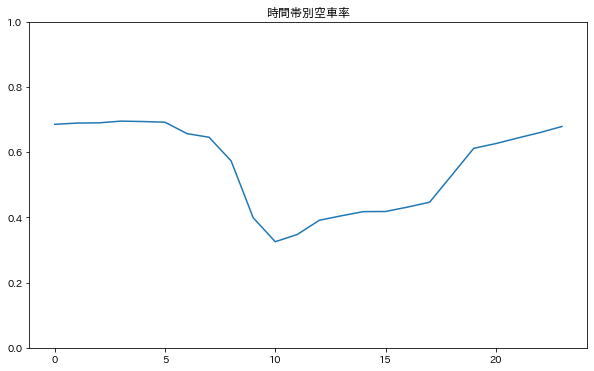

In [41]:
from random import randint
i = randint(0, 60)
print(i)
available_rate_by_hour = merge_df.loc[merge_df['station_id']==i].groupby('hour')['available_rate'].mean()
plt.figure(figsize=(10, 6))
plt.plot(available_rate_by_hour.index, available_rate_by_hour.values)
plt.title('時間帯別空車率')
plt.ylim([0.0, 1.0])
plt.show()

In [42]:
# 日付から曜日情報を取得
merge_df['weekday'] = merge_df['date'].dt.weekday
merge_df['weekday_name'] = merge_df['date'].dt.day_name()

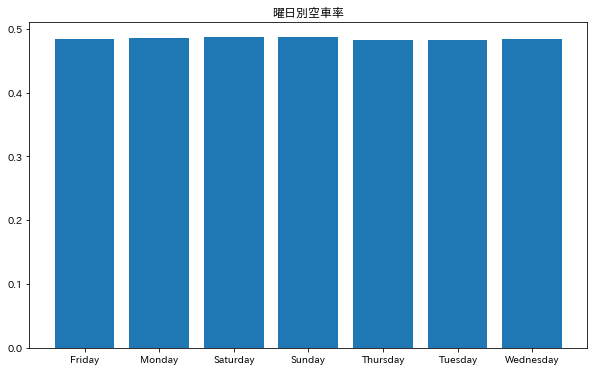

In [43]:
available_rate_by_weekday = merge_df.groupby('weekday_name')['available_rate'].mean()
plt.figure(figsize=(10, 6))
plt.bar(available_rate_by_weekday.index, available_rate_by_weekday.values)
plt.title('曜日別空車率')
plt.show()

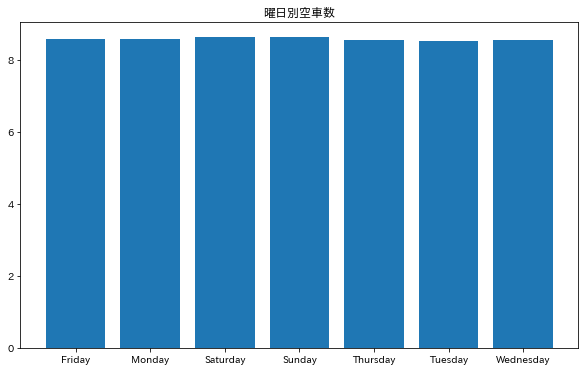

In [44]:
available_bikes_by_weekday = merge_df.groupby('weekday_name')['bikes_available'].mean()
plt.figure(figsize=(10, 6))
plt.bar(available_bikes_by_weekday.index, available_bikes_by_weekday.values)
plt.title('曜日別空車数')
plt.show()

## Status & Station & Weather
- 前述の結合データにさらにWeatherを結合
- 全体の10%が雨、1%が霧であるが、天候によって空車台数はかわらない

In [45]:
merge_df = pd.merge(merge_df, weather, on='date', how='left')
merge_df

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,city,installation_date,available_rate,weekday,weekday_name,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,events,wind_dir_degrees
0,0,2013,9,1,0,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06,0.41,6,Sunday,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354
1,1,2013,9,1,1,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06,0.41,6,Sunday,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354
2,2,2013,9,1,2,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06,0.41,6,Sunday,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354
3,3,2013,9,1,3,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06,0.41,6,Sunday,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354
4,4,2013,9,1,4,0,11.00,0,2013-09-01,37.33,-121.90,27,city1,2013-08-06,0.41,6,Sunday,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613195,1217635,2014,8,31,19,69,10.00,0,2014-08-31,37.34,-121.90,15,city1,2014-04-09,0.67,6,Sunday,79,69,59,60,58,56,90,69,48,29.96,29.91,29.85,10,10,10,21,6,0.00,0,NaN,356
613196,1217636,2014,8,31,20,69,10.00,0,2014-08-31,37.34,-121.90,15,city1,2014-04-09,0.67,6,Sunday,79,69,59,60,58,56,90,69,48,29.96,29.91,29.85,10,10,10,21,6,0.00,0,NaN,356
613197,1217637,2014,8,31,21,69,10.00,0,2014-08-31,37.34,-121.90,15,city1,2014-04-09,0.67,6,Sunday,79,69,59,60,58,56,90,69,48,29.96,29.91,29.85,10,10,10,21,6,0.00,0,NaN,356
613198,1217638,2014,8,31,22,69,10.00,0,2014-08-31,37.34,-121.90,15,city1,2014-04-09,0.67,6,Sunday,79,69,59,60,58,56,90,69,48,29.96,29.91,29.85,10,10,10,21,6,0.00,0,NaN,356


In [46]:
merge_df['events'].value_counts() / len(merge_df)

Rain   0.10
Fog    0.01
Name: events, dtype: float64

In [47]:
print(merge_df['bikes_available'].mean())
merge_df.groupby('events')['bikes_available'].mean()

8.58047988911333


events
Fog    8.53
Rain   8.72
Name: bikes_available, dtype: float64

In [48]:
print(merge_df['available_rate'].mean())
merge_df.groupby('events')['available_rate'].mean()

0.4845167610063345


events
Fog    0.48
Rain   0.49
Name: available_rate, dtype: float64

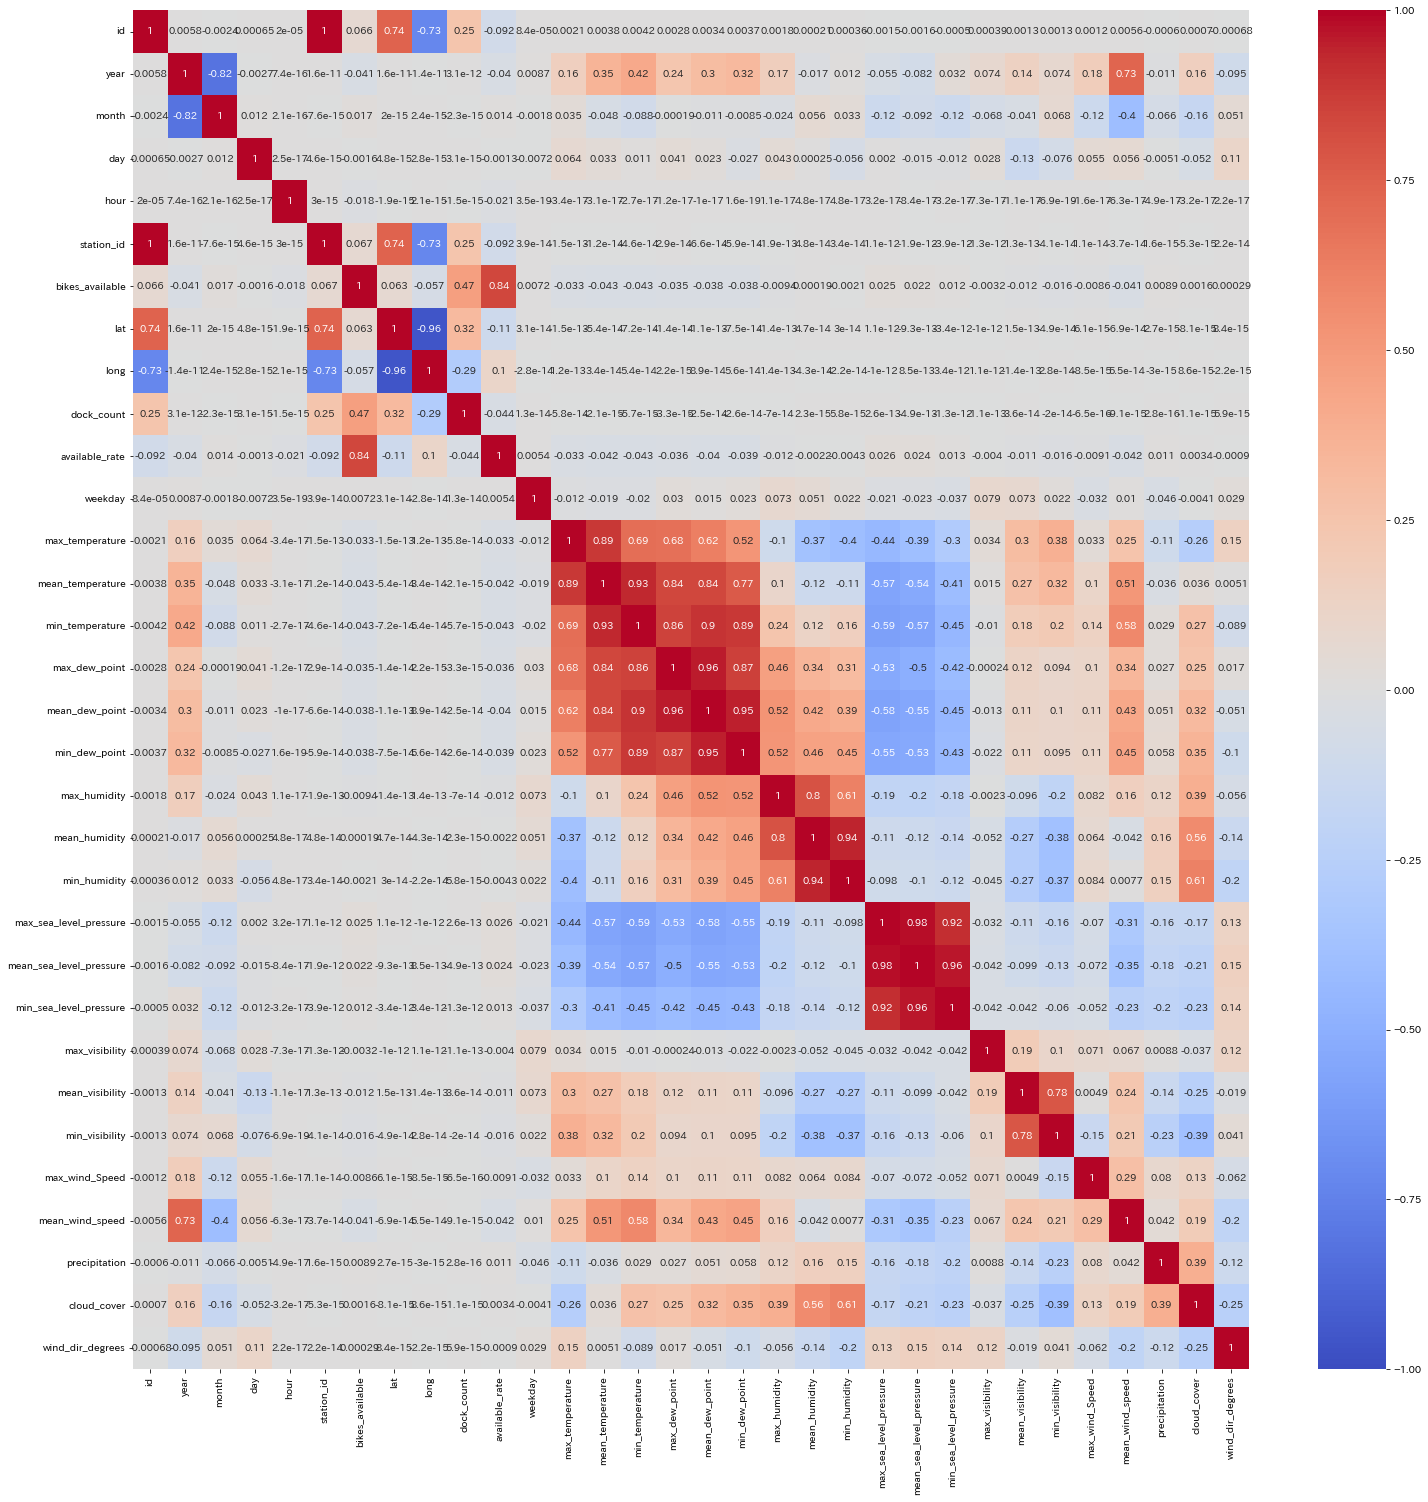

In [49]:
corr = merge_df.drop('predict', axis=1).corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

# すべてのデータを結合するための関数を作成
年、月、日、時間、ステーションIDをキーとして結合する

## Status
- 曜日情報と空車台数(目的変数)、ステーションID

## Station
- ステーションIDをキーとしてStatusに結合(設置日は除く)
- 空車台数とドック数をもとに空車率を算出

## Weather
- 年、月、日をキーとしてすべてのカラムを結合
- 前日のデータと1週間前の同曜日のデータも同様に結合

## Trip
以下のデータを結合
1. 貸出時刻、貸出ステーションをもとに貸出数、平均利用時間、定額プラン利用者の数を算出
2. 返却時刻、返却ステーションをもとに貸出数、平均利用時間、定額プラン利用者の数を算出
3. 前日のデータと1週間前の同曜日のデータも同様に算出
4. 1~3の処理をステーション別、都市別にも行う

## データ探索
- 上記の手順で作成したデータセットに対するデータ探索
- 作成したカラムのうち欠損となっているものはその時間帯に返却や貸出がなかったことを示す

In [50]:
def create_df():
    station = pd.read_csv('station.csv', parse_dates=['installation_date'])
    status = pd.read_csv('status.csv')
    trip = pd.read_csv('trip.csv')
    trip['start_date'] = pd.to_datetime(trip['start_date'])
    trip['end_date'] = pd.to_datetime(trip['end_date'])
    weather = pd.read_csv('weather.csv', parse_dates=['date'])

    status['date_time'] = pd.to_datetime(status[['year', 'month', 'day', 'hour']])
    status['date'] = status['date_time'].dt.date.apply(lambda x: x.strftime('%Y-%m-%d'))
    status['weekday'] = status['date_time'].dt.dayofweek
    merge_df = pd.merge(status, station.drop('installation_date', axis=1), on=['station_id'], how='left')
    merge_df['available_rate'] = merge_df['bikes_available'] / merge_df['dock_count']
    available_rate = merge_df[['date', 'available_rate', 'hour', 'station_id']]
    available_rate['date'] = pd.to_datetime(available_rate['date'])
    available_rate['date'] += datetime.timedelta(days=1)
    available_rate['year'] = available_rate['date'].dt.strftime('%Y')
    available_rate['month'] = available_rate['date'].dt.strftime('%m')
    available_rate['day'] = available_rate['date'].dt.strftime('%d')
    available_rate['year'] = available_rate['year'].astype(np.int16)
    available_rate['month'] = available_rate['month'].astype(np.int16)
    available_rate['day'] = available_rate['day'].astype(np.int16)
    available_rate.drop(['date'], axis=1, inplace=True)
    merge_df = pd.merge(merge_df, available_rate, on=['year', 'month', 'day', 'hour', 'station_id'], how='left')
    merge_df.rename(columns={'available_rate_y': 'former_available_rate'}, inplace=True)
    merge_df.drop('available_rate_x', axis=1, inplace=True)

    weather['year'] = weather['date'].dt.strftime('%Y')
    weather['month'] = weather['date'].dt.strftime('%m')
    weather['day'] = weather['date'].dt.strftime('%d')
    weather['year'] = weather['year'].astype(np.int16)
    weather['month'] = weather['month'].astype(np.int16)
    weather['day'] = weather['day'].astype(np.int16)
    columns = weather.columns[1:-5]
    for column in columns:
        weather[f'{column}_1'] = weather[column].shift(1)
        weather[f'{column}_1w'] = weather[column].rolling(7).mean()
    merge_df = pd.merge(merge_df, weather, on=['year', 'month', 'day'], how='left')

    trip['start_date'] = pd.to_datetime(trip['start_date'])
    trip['end_date'] = pd.to_datetime(trip['end_date'])
    trip['start_date'] = pd.to_datetime(trip['start_date'])
    trip['end_date'] = pd.to_datetime(trip['end_date'])
    trip['start_year'] = trip['start_date'].dt.strftime('%Y')
    trip['start_month'] = trip['start_date'].dt.strftime('%m')
    trip['start_day'] = trip['start_date'].dt.strftime('%d')
    trip['start_hour'] = trip['start_date'].dt.strftime('%H')
    trip['start_year'] = trip['start_year'].astype(np.int16)
    trip['start_month'] = trip['start_month'].astype(np.int16)
    trip['start_day'] = trip['start_day'].astype(np.int16)
    trip['start_hour'] = trip['start_hour'].astype(np.int16)
    trip['end_year'] = trip['end_date'].dt.strftime('%Y')
    trip['end_month'] = trip['end_date'].dt.strftime('%m')
    trip['end_day'] = trip['end_date'].dt.strftime('%d')
    trip['end_hour'] = trip['end_date'].dt.strftime('%H')
    trip['end_year'] = trip['end_year'].astype(np.int16)
    trip['end_month'] = trip['end_month'].astype(np.int16)
    trip['end_day'] = trip['end_day'].astype(np.int16)
    trip['end_hour'] = trip['end_hour'].astype(np.int16)
    rent = pd.DataFrame(trip.groupby(['start_year', 'start_month', 'start_day', 'start_hour', 'start_station_id'])['trip_id'].count())
    rent.reset_index(inplace=True)
    rent.columns = ['year', 'month', 'day', 'hour', 'station_id', 'rent_count']
    return_ = pd.DataFrame(trip.groupby(['end_year', 'end_month', 'end_day', 'end_hour', 'end_station_id'])['trip_id'].count())
    return_.reset_index(inplace=True)
    return_.columns = ['year', 'month', 'day', 'hour', 'station_id', 'return_count']
    mean_duration = pd.DataFrame(trip.groupby(['end_year', 'end_month', 'end_day', 'end_hour', 'end_station_id'])['duration'].mean())
    mean_duration.reset_index(inplace=True)
    mean_duration.columns = ['year', 'month', 'day', 'hour', 'station_id', 'mean_duration']
    start_subscriber = pd.DataFrame(trip.loc[trip['subscription_type']=='Subscriber'].groupby(['start_year', 'start_month', 'start_day', 'start_hour', 'start_station_id'])['trip_id'].count())
    start_subscriber.reset_index(inplace=True)
    start_subscriber.columns = ['year', 'month', 'day', 'hour', 'station_id', 'start_subscriber']
    end_subscriber = pd.DataFrame(trip.loc[trip['subscription_type']=='Subscriber'].groupby(['end_year', 'end_month', 'end_day', 'end_hour', 'end_station_id'])['trip_id'].count())
    end_subscriber.reset_index(inplace=True)
    end_subscriber.columns = ['year', 'month', 'day', 'hour', 'station_id', 'end_subscriber']
    trip_df = pd.merge(rent, return_, on=['year', 'month', 'day', 'hour', 'station_id'], how='left')
    trip_df = pd.merge(trip_df, mean_duration, on=['year', 'month', 'day', 'hour', 'station_id'], how='left')
    trip_df = pd.merge(trip_df, start_subscriber, on=['year', 'month', 'day', 'hour', 'station_id'], how='left')
    trip_df = pd.merge(trip_df, end_subscriber, on=['year', 'month', 'day', 'hour', 'station_id'], how='left')
    trip_df.fillna(0, inplace=True)
    trip_df['start_end_ratio'] = trip_df['rent_count'] / trip_df['return_count']
    trip_df['date_time'] = pd.to_datetime(trip_df[['year', 'month', 'day', 'hour']])
    trip_df['datetime_1'] = trip_df['date_time'] + datetime.timedelta(days=1)
    trip_df['datetime_2'] = trip_df['date_time'] + datetime.timedelta(days=7)
    trip_df['year_1'] = trip_df['datetime_1'].dt.strftime('%Y')
    trip_df['month_1'] = trip_df['datetime_1'].dt.strftime('%m')
    trip_df['day_1'] = trip_df['datetime_1'].dt.strftime('%d')
    trip_df['hour_1'] = trip_df['datetime_1'].dt.strftime('%H')
    trip_df['year_7'] = trip_df['datetime_2'].dt.strftime('%Y')
    trip_df['month_7'] = trip_df['datetime_2'].dt.strftime('%m')
    trip_df['day_7'] = trip_df['datetime_2'].dt.strftime('%d')
    trip_df['hour_7'] = trip_df['datetime_2'].dt.strftime('%H')
    trip_df['year_1'] = trip_df['year_1'].astype(np.int16)
    trip_df['month_1'] = trip_df['month_1'].astype(np.int16)
    trip_df['day_1'] = trip_df['day_1'].astype(np.int16)
    trip_df['hour_1'] = trip_df['hour_1'].astype(np.int16)
    trip_df['year_7'] = trip_df['year_7'].astype(np.int16)
    trip_df['month_7'] = trip_df['month_7'].astype(np.int16)
    trip_df['day_7'] = trip_df['day_7'].astype(np.int16)
    trip_df['hour_7'] = trip_df['hour_7'].astype(np.int16)
    trip_df.drop(['date_time', 'datetime_1', 'datetime_2'], axis=1, inplace=True)
    main_df = pd.merge(merge_df, trip_df, left_on=['year', 'month', 'day', 'hour', 'station_id'], right_on=['year_1', 'month_1', 'day_1', 'hour_1', 'station_id'], how='left')
    main_df.rename(columns={'rent_count': 'rent_count_1', 
                            'return_count': 'return_count_1',
                            'mean_duration': 'mean_duration_1',
                            'start_subscriber': 'start_subscriber_1',
                            'end_subscriber': 'end_subscriber_1',
                            'start_end_ratio': 'start_end_ratio_1',
                            'year_x': 'year',
                            'month_x': 'month',
                            'day_x': 'day',
                            'hour_x': 'hour'}, inplace=True)
    main_df = pd.merge(main_df, trip_df, left_on=['year', 'month', 'day', 'hour', 'station_id'], right_on=['year_7', 'month_7', 'day_7', 'hour_7', 'station_id'], how='left')
    main_df.rename(columns={'rent_count': 'rent_count_7', 
                            'return_count': 'return_count_7',
                            'mean_duration': 'mean_duration_7',
                            'start_subscriber': 'start_subscriber_7',
                            'end_subscriber': 'end_subscriber_7',
                            'start_end_ratio': 'start_end_ratio_7',
                            'year_x': 'year',
                            'month_x': 'month',
                            'day_x': 'day',
                            'hour_x': 'hour'}, inplace=True)
    trip_ = trip.copy()
    station = pd.read_csv('station.csv', parse_dates=['installation_date'])
    trip_station = pd.merge(trip_, station[['station_id', 'city']], left_on='start_station_id', right_on='station_id', how='left')
    trip_station.rename(columns={'city': 'start_city'}, inplace=True)
    trip_station = pd.merge(trip_station, station[['station_id', 'city']], left_on='end_station_id', right_on='station_id', how='left')
    trip_station.rename(columns={'city': 'end_city'}, inplace=True)
    trip_station.head()
    rent_by_city = pd.DataFrame(trip_station.groupby(['start_year', 'start_month', 'start_day', 'start_hour', 'start_city'])['trip_id'].count())
    rent_by_city.reset_index(inplace=True)
    rent_by_city.columns = ['year', 'month', 'day', 'hour', 'city', 'rent_count_by_city']
    return_by_city = pd.DataFrame(trip_station.groupby(['end_year', 'end_month', 'end_day', 'end_hour', 'end_city'])['trip_id'].count())
    return_by_city.reset_index(inplace=True)
    return_by_city.columns = ['year', 'month', 'day', 'hour', 'city', 'return_count_by_city']
    mean_duration_by_city = pd.DataFrame(trip_station.groupby(['end_year', 'end_month', 'end_day', 'end_hour', 'end_city'])['duration'].mean())
    mean_duration_by_city.reset_index(inplace=True)
    mean_duration_by_city.columns = ['year', 'month', 'day', 'hour', 'city', 'mean_duration_by_city']
    trip_station_df = pd.merge(rent_by_city, return_by_city, on=['year', 'month', 'day', 'hour', 'city'], how='left')
    trip_station_df = pd.merge(trip_station_df, mean_duration_by_city, on=['year', 'month', 'day', 'hour', 'city'], how='left')
    trip_station_df.fillna(0, inplace=True)
    trip_station_df['start_end_ratio_by_city'] = trip_station_df['rent_count_by_city'] / trip_station_df['return_count_by_city']
    trip_station_df['date_time'] = pd.to_datetime(trip_station_df[['year', 'month', 'day', 'hour']])
    trip_station_df['datetime_1'] = trip_station_df['date_time'] + datetime.timedelta(days=1)
    trip_station_df['datetime_2'] = trip_station_df['date_time'] + datetime.timedelta(days=7)
    trip_station_df['year_1'] = trip_station_df['datetime_1'].dt.strftime('%Y')
    trip_station_df['month_1'] = trip_station_df['datetime_1'].dt.strftime('%m')
    trip_station_df['day_1'] = trip_station_df['datetime_1'].dt.strftime('%d')
    trip_station_df['hour_1'] = trip_station_df['datetime_1'].dt.strftime('%H')
    trip_station_df['year_7'] = trip_station_df['datetime_2'].dt.strftime('%Y')
    trip_station_df['month_7'] = trip_station_df['datetime_2'].dt.strftime('%m')
    trip_station_df['day_7'] = trip_station_df['datetime_2'].dt.strftime('%d')
    trip_station_df['hour_7'] = trip_station_df['datetime_2'].dt.strftime('%H')
    trip_station_df['year_1'] = trip_station_df['year_1'].astype(np.int16)
    trip_station_df['month_1'] = trip_station_df['month_1'].astype(np.int16)
    trip_station_df['day_1'] = trip_station_df['day_1'].astype(np.int16)
    trip_station_df['hour_1'] = trip_station_df['hour_1'].astype(np.int16)
    trip_station_df['year_7'] = trip_station_df['year_7'].astype(np.int16)
    trip_station_df['month_7'] = trip_station_df['month_7'].astype(np.int16)
    trip_station_df['day_7'] = trip_station_df['day_7'].astype(np.int16)
    trip_station_df['hour_7'] = trip_station_df['hour_7'].astype(np.int16)
    trip_station_df.drop(['date_time', 'datetime_1', 'datetime_2'], axis=1, inplace=True)
    main_df = pd.merge(main_df, trip_station_df, left_on=['year', 'month', 'day', 'hour', 'city'], right_on=['year_1', 'month_1', 'day_1', 'hour_1', 'city'], how='left')
    main_df.rename(columns={'rent_count_by_city': 'rent_count_by_city_1',
                            'return_count_by_city': 'return_count_by_city_1',
                            'mean_duration_by_city': 'mean_duration_by_city_1',
                            'start_end_ratio_by_city': 'start_end_ratio_by_city_1',
                            'year_x': 'year',
                            'month_x': 'month',
                            'day_x': 'day',
                            'hour_x': 'hour'}, inplace=True)
    main_df = pd.merge(main_df, trip_station_df, left_on=['year', 'month', 'day', 'hour', 'city'], right_on=['year_7', 'month_7', 'day_7', 'hour_7', 'city'], how='left')
    main_df.rename(columns={'rent_count_by_city': 'rent_count_by_city_7',
                            'return_count_by_city': 'return_count_by_city_7',
                            'mean_duration_by_city': 'mean_duration_by_city_7',
                            'start_end_ratio_by_city': 'start_end_ratio_by_city_7',
                            'year_x': 'year',
                            'month_x': 'month',
                            'day_x': 'day',
                            'hour_x': 'hour'}, inplace=True)
    main_df.drop(['date_x', 'lat', 'long', 'date_y', 'year_1_x', 'month_1_x', 'day_1_x', 'hour_1_x', 'year_7_x', 'month_7_x', 'day_7_x', 'hour_7_x', 'year_y',
                  'month_y', 'day_y', 'hour_y', 'year_1_y', 'month_1_y', 'day_1_y', 'hour_1_y', 'year_7_y', 'month_7_y', 'day_7_y', 'hour_7_y'], axis=1, inplace=True)
    return main_df

In [51]:
main_df = create_df()

In [52]:
main_df

,id,year,month,day,hour,station_id,bikes_available,predict,date_time,weekday,dock_count,city,former_available_rate,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,events,wind_dir_degrees,max_temperature_1,max_temperature_1w,mean_temperature_1,mean_temperature_1w,min_temperature_1,min_temperature_1w,max_dew_point_1,max_dew_point_1w,mean_dew_point_1,mean_dew_point_1w,min_dew_point_1,min_dew_point_1w,max_humidity_1,max_humidity_1w,mean_humidity_1,mean_humidity_1w,min_humidity_1,min_humidity_1w,max_sea_level_pressure_1,max_sea_level_pressure_1w,mean_sea_level_pressure_1,mean_sea_level_pressure_1w,min_sea_level_pressure_1,min_sea_level_pressure_1w,max_visibility_1,max_visibility_1w,mean_visibility_1,mean_visibility_1w,min_visibility_1,min_visibility_1w,max_wind_Speed_1,max_wind_Speed_1w,mean_wind_speed_1,mean_wind_speed_1w,precipitation_1,precipitation_1w,cloud_cover_1,cloud_cover_1w,rent_count_1,return_count_1,mean_duration_1,start_subscriber_1,end_subscriber_1,start_end_ratio_1,rent_count_7,return_count_7,mean_duration_7,start_subscriber_7,end_subscriber_7,start_end_ratio_7,rent_count_by_city_1,return_count_by_city_1,mean_duration_by_city_1,start_end_ratio_by_city_1,rent_count_by_city_7,return_count_by_city_7,mean_duration_by_city_7,start_end_ratio_by_city_7
0,0,2013,9,1,0,0,11.00,0,2013-09-01 00:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,1.00,300.00,2.00,NaN,NaN,NaN,NaN
1,1,2013,9,1,1,0,11.00,0,2013-09-01 01:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013,9,1,2,0,11.00,0,2013-09-01 02:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013,9,1,3,0,11.00,0,2013-09-01 03:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013,9,1,4,0,11.00,0,2013-09-01 04:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.00,0,2015-08-31 19:00:00,0,15,city1,NaN,82,72,61,62,56,52,84,63,42,29.97,29.92,29.86,10,10,10,22,6,0.00,0,NaN,6,79.00,83.00,70.00,72.71,61.00,61.86,60.00,61.57,55.00,57.71,51.00,52.14,78.00,84.00,63.00,63.14,47.00,41.71,30.08

In [53]:
# 欠損値の確認
# 作成したカラムの欠損が多い
main_df.isnull().sum() / len(main_df)

id                           0.00
year                         0.00
month                        0.00
day                          0.00
hour                         0.00
station_id                   0.00
bikes_available              0.34
predict                      0.00
date_time                    0.00
weekday                      0.00
dock_count                   0.00
city                         0.00
former_available_rate        0.34
max_temperature              0.00
mean_temperature             0.00
min_temperature              0.00
max_dew_point                0.00
mean_dew_point               0.00
min_dew_point                0.00
max_humidity                 0.00
mean_humidity                0.00
min_humidity                 0.00
max_sea_level_pressure       0.00
mean_sea_level_pressure      0.00
min_sea_level_pressure       0.00
max_visibility               0.00
mean_visibility              0.00
min_visibility               0.00
max_wind_Speed               0.00
mean_wind_spee

In [54]:
# 欠損の内容を確認
main_df.loc[main_df['rent_count_1'].isnull()]

,id,year,month,day,hour,station_id,bikes_available,predict,date_time,weekday,dock_count,city,former_available_rate,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,events,wind_dir_degrees,max_temperature_1,max_temperature_1w,mean_temperature_1,mean_temperature_1w,min_temperature_1,min_temperature_1w,max_dew_point_1,max_dew_point_1w,mean_dew_point_1,mean_dew_point_1w,min_dew_point_1,min_dew_point_1w,max_humidity_1,max_humidity_1w,mean_humidity_1,mean_humidity_1w,min_humidity_1,min_humidity_1w,max_sea_level_pressure_1,max_sea_level_pressure_1w,mean_sea_level_pressure_1,mean_sea_level_pressure_1w,min_sea_level_pressure_1,min_sea_level_pressure_1w,max_visibility_1,max_visibility_1w,mean_visibility_1,mean_visibility_1w,min_visibility_1,min_visibility_1w,max_wind_Speed_1,max_wind_Speed_1w,mean_wind_speed_1,mean_wind_speed_1w,precipitation_1,precipitation_1w,cloud_cover_1,cloud_cover_1w,rent_count_1,return_count_1,mean_duration_1,start_subscriber_1,end_subscriber_1,start_end_ratio_1,rent_count_7,return_count_7,mean_duration_7,start_subscriber_7,end_subscriber_7,start_end_ratio_7,rent_count_by_city_1,return_count_by_city_1,mean_duration_by_city_1,start_end_ratio_by_city_1,rent_count_by_city_7,return_count_by_city_7,mean_duration_by_city_7,start_end_ratio_by_city_7
0,0,2013,9,1,0,0,11.00,0,2013-09-01 00:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,1.00,300.00,2.00,NaN,NaN,NaN,NaN
1,1,2013,9,1,1,0,11.00,0,2013-09-01 01:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013,9,1,2,0,11.00,0,2013-09-01 02:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013,9,1,3,0,11.00,0,2013-09-01 03:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013,9,1,4,0,11.00,0,2013-09-01 04:00:00,6,27,city1,NaN,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.00,1,NaN,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.00,0,2015-08-31 19:00:00,0,15,city1,NaN,82,72,61,62,56,52,84,63,42,29.97,29.92,29.86,10,10,10,22,6,0.00,0,NaN,6,79.00,83.00,70.00,72.71,61.00,61.86,60.00,61.57,55.00,57.71,51.00,52.14,78.00,84.00,63.00,63.14,47.00,41.71,30.08

In [55]:
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
trip['start_year'] = trip['start_date'].dt.strftime('%Y')
trip['start_month'] = trip['start_date'].dt.strftime('%m')
trip['start_day'] = trip['start_date'].dt.strftime('%d')
trip['start_hour'] = trip['start_date'].dt.strftime('%H')
trip['start_year'] = trip['start_year'].astype(np.int16)
trip['start_month'] = trip['start_month'].astype(np.int16)
trip['start_day'] = trip['start_day'].astype(np.int16)
trip['start_hour'] = trip['start_hour'].astype(np.int16)
trip['end_year'] = trip['end_date'].dt.strftime('%Y')
trip['end_month'] = trip['end_date'].dt.strftime('%m')
trip['end_day'] = trip['end_date'].dt.strftime('%d')
trip['end_hour'] = trip['end_date'].dt.strftime('%H')
trip['end_year'] = trip['end_year'].astype(np.int16)
trip['end_month'] = trip['end_month'].astype(np.int16)
trip['end_day'] = trip['end_day'].astype(np.int16)
trip['end_hour'] = trip['end_hour'].astype(np.int16)

In [56]:
trip.loc[(trip['start_year']==2013)&(trip['start_month']==9)&(trip['start_day']==1)&(trip['start_hour']==2)]

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type,start_year,start_month,start_day,start_hour,end_year,end_month,end_day,end_hour
2114,2114,447,2013-09-01 02:01:00,55,2013-09-01 02:08:00,65,117,Subscriber,2013,9,1,2,2013,9,1,2
2115,2115,1124,2013-09-01 02:04:00,39,2013-09-01 02:23:00,54,428,Customer,2013,9,1,2,2013,9,1,2
2116,2116,1259,2013-09-01 02:04:00,39,2013-09-01 02:25:00,54,13,Customer,2013,9,1,2,2013,9,1,2
2117,2117,194,2013-09-01 02:09:00,65,2013-09-01 02:12:00,39,213,Subscriber,2013,9,1,2,2013,9,1,2
2118,2118,609,2013-09-01 02:19:00,63,2013-09-01 02:29:00,55,234,Subscriber,2013,9,1,2,2013,9,1,2
2119,2119,87,2013-09-01 02:27:00,54,2013-09-01 02:29:00,54,13,Customer,2013,9,1,2,2013,9,1,2


# モデル構築

## データ分割
- 7日前までの情報を用いるためデータセットを2013/9/8以降に限定する
- 2013/9/8~2014/8/31: 学習データ
- 2014/9/1~2015/8/31, predicti=1: テストデータ
- 2014/9/1~2015/8/31, predicti=0: 検証データ

In [57]:
train_df = main_df.loc[main_df['date_time'] < '2014-09-01']
train_df = train_df.loc[train_df['date_time'] >= '2013-09-08']
evaluate_df = main_df.loc[(main_df['date_time'] >= '2014-09-01') & (main_df['predict']==0)]
test_df = main_df.loc[(main_df['date_time'] >= '2014-09-01') & (main_df['predict']==1)]
train_df = train_df.loc[~train_df['bikes_available'].isnull()]
evaluate_df = evaluate_df.loc[~evaluate_df['bikes_available'].isnull()]

## 特徴量生成
- 雨、霧の日を1, その他の日を0とするダミー変数
- 都市名をラベルエンコーディング
- 返却数などのデータをドック数で割る
- 時刻が9-16時の間であれば1をとるダミー変数

In [58]:
from sklearn.preprocessing import LabelEncoder
# 天候情報
train_df['events'] = train_df['events'].apply(lambda x: 1 if x is None else 0)
evaluate_df['events'] = evaluate_df['events'].apply(lambda x: 1 if x is None else 0)
test_df['events'] = test_df['events'].apply(lambda x: 1 if x is None else 0)
# 都市名をラベルエンコーディング
le = LabelEncoder()
encoded = le.fit_transform(train_df['city'].values)
train_df['city'] = encoded
encoded = le.fit_transform(evaluate_df['city'].values)
evaluate_df['city'] = encoded
encoded = le.fit_transform(test_df['city'].values)
test_df['city'] = encoded
# 返却数等をドック数で割る
train_df['rent_per_dock_1'] = train_df['rent_count_1'] / train_df['dock_count']
train_df['return_per_dock_1'] = train_df['return_count_1'] / train_df['dock_count']
train_df['start_subscriber_per_dock_1'] = train_df['start_subscriber_1'] / train_df['dock_count']
train_df['end_subscriber_per_dock_1'] = train_df['end_subscriber_1'] / train_df['dock_count']
evaluate_df['rent_per_dock_1'] = evaluate_df['rent_count_1'] / evaluate_df['dock_count']
evaluate_df['return_per_dock_1'] = evaluate_df['return_count_1'] / evaluate_df['dock_count']
evaluate_df['start_subscriber_per_dock_1'] = evaluate_df['start_subscriber_1'] / evaluate_df['dock_count']
evaluate_df['end_subscriber_per_dock_1'] = evaluate_df['end_subscriber_1'] / evaluate_df['dock_count']
test_df['rent_per_dock_1'] = test_df['rent_count_1'] / test_df['dock_count']
test_df['return_per_dock_1'] = test_df['return_count_1'] / test_df['dock_count']
test_df['start_subscriber_per_dock_1'] = test_df['start_subscriber_1'] / test_df['dock_count']
test_df['end_subscriber_per_dock_1'] = test_df['end_subscriber_1'] / test_df['dock_count']
train_df['rent_per_dock_7'] = train_df['rent_count_7'] / train_df['dock_count']
train_df['return_per_dock_7'] = train_df['return_count_7'] / train_df['dock_count']
train_df['start_subscriber_per_dock_7'] = train_df['start_subscriber_7'] / train_df['dock_count']
train_df['end_subscriber_per_dock_7'] = train_df['end_subscriber_7'] / train_df['dock_count']
evaluate_df['rent_per_dock_7'] = evaluate_df['rent_count_7'] / evaluate_df['dock_count']
evaluate_df['return_per_dock_7'] = evaluate_df['return_count_7'] / evaluate_df['dock_count']
evaluate_df['start_subscriber_per_dock_7'] = evaluate_df['start_subscriber_7'] / evaluate_df['dock_count']
evaluate_df['end_subscriber_per_dock_7'] = evaluate_df['end_subscriber_7'] / evaluate_df['dock_count']
test_df['rent_per_dock_7'] = test_df['rent_count_7'] / test_df['dock_count']
test_df['return_per_dock_7'] = test_df['return_count_7'] / test_df['dock_count']
test_df['start_subscriber_per_dock_7'] = test_df['start_subscriber_7'] / test_df['dock_count']
test_df['end_subscriber_per_dock_7'] = test_df['end_subscriber_7'] / test_df['dock_count']
# 時刻ダミー
train_df['daytime'] = train_df['hour'].apply(lambda x: 1 if x>=9 and x<=16 else 0)
evaluate_df['daytime'] = evaluate_df['hour'].apply(lambda x: 1 if x>=9 and x<=16 else 0)
test_df['daytime'] = test_df['hour'].apply(lambda x: 1 if x>=9 and x<=16 else 0)

## Light GBMで予測
- kfoldにより交差検証を行う
- 最終的な予測値は5つのモデルにより算出された予測値の平均とする
- RMSEは3.54前後

In [59]:
# 使う特徴量の選定
columns = ['year', 'month', 'day', 'hour', 'station_id', 'weekday', 'dock_count', 'city', 'events', 'daytime', 'former_available_rate',
           'rent_per_dock_1', 'rent_per_dock_7', 'return_per_dock_1', 'return_per_dock_7', 'start_subscriber_per_dock_1', 'start_subscriber_per_dock_7',
           'end_subscriber_per_dock_1', 'end_subscriber_per_dock_7',
           'mean_temperature', 'mean_dew_point', 'mean_wind_speed', 'precipitation', 'cloud_cover',
           'mean_temperature_1', 'mean_dew_point_1', 'mean_wind_speed_1', 'precipitation_1', 'cloud_cover_1']
X = train_df[columns]
X.fillna(0, inplace=True)
X_evaluate = evaluate_df[columns]
X_test = test_df[columns]
y = train_df['bikes_available']
y_evaluate = evaluate_df['bikes_available']

In [60]:
# 交差検証によりモデルを作成して予測を行う

import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

rmse_list = []
model_list = []
pred_list = []

kf = KFold(n_splits=5, shuffle=True, random_state=0)

for index, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f'{index+1}回目')
    X_train = X.iloc[train_index]
    X_valid = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[test_index]
    
    gbm = lgb.LGBMRegressor(objective='mse', bagging_fraction=0.5, colsample_bytree=1, n_estimators=10000, learning_rate=0.01,
                         max_depth=5, min_child_samples=200, num_leaves=255, random_state=0, reg_alpha=1.5, reg_lambda=2)
    
    eval_set = [(X_valid, y_valid)]
    callbacks = []
    callbacks.append(lgb.early_stopping(stopping_rounds=10))
    callbacks.append(lgb.log_evaluation())
    gbm.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
    
    y_train_pred = gbm.predict(X_train)
    y_valid_pred = gbm.predict(X_valid)
    y_evaluate_pred = gbm.predict(X_evaluate)
    y_test_pred = gbm.predict(X_test)
    train_mse = mean_squared_error(y_train_pred, y_train)
    valid_mse = mean_squared_error(y_valid_pred, y_valid)
    evaluate_mse = mean_squared_error(y_evaluate_pred, y_evaluate)
    train_rmse = np.sqrt(train_mse)
    valid_rmse = np.sqrt(valid_mse)
    evaluate_rmse = np.sqrt(evaluate_mse)
    print(f'学習データRMSE: {train_rmse}')
    print(f'検証データRMSE: {valid_rmse}')
    rmse_list.append(evaluate_rmse)
    pred_list.append(y_test_pred)

1回目
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's l2: 14.0751
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 13.9755
[3]	valid_0's l2: 13.878
[4]	valid_0's l2: 13.7823
[5]	valid_0's l2: 13.6886
[6]	valid_0's l2: 13.5969
[7]	valid_0's l2: 13.5068
[8]	valid_0's l2: 13.4186
[9]	valid_0's l2: 13.3321
[10]	valid_0's l2: 13.2472
[11]	valid_0's l2: 13.1641
[12]	valid_0's l2: 13.0827
[13]	valid_0's l2: 13.0026
[14]	valid_0's l2: 12.9244
[15]	valid_0's l2: 12.8477
[16]	valid_0's l2: 12.7723
[17]	valid_0's l2: 12.6983
[18]	valid_0's l2: 12.6258
[19]	valid_0's l2: 12.5548
[20]	valid_0's l2: 12.485
[21]	valid_0's l2: 12.4169
[22]	valid_0's l2: 12.3499
[23]	valid_0's l2: 12.2842
[24]	valid_0's l2: 12.2197
[25]	valid_0's l2: 12.1562
[26]	valid_0's l2: 12.0945
[27]	valid_0's l2: 12.0339
[28]	valid_0's l2: 11.9744
[29]	valid_0's l2: 11.916
[30]	valid_0's l2: 11.8588
[31]	valid_0's l2: 1

In [61]:
print(rmse_list)

[3.5536094045907913, 3.533682412715398, 3.541065851811445, 3.561579978453426, 3.5489761957624895]


## 特徴量の重要度

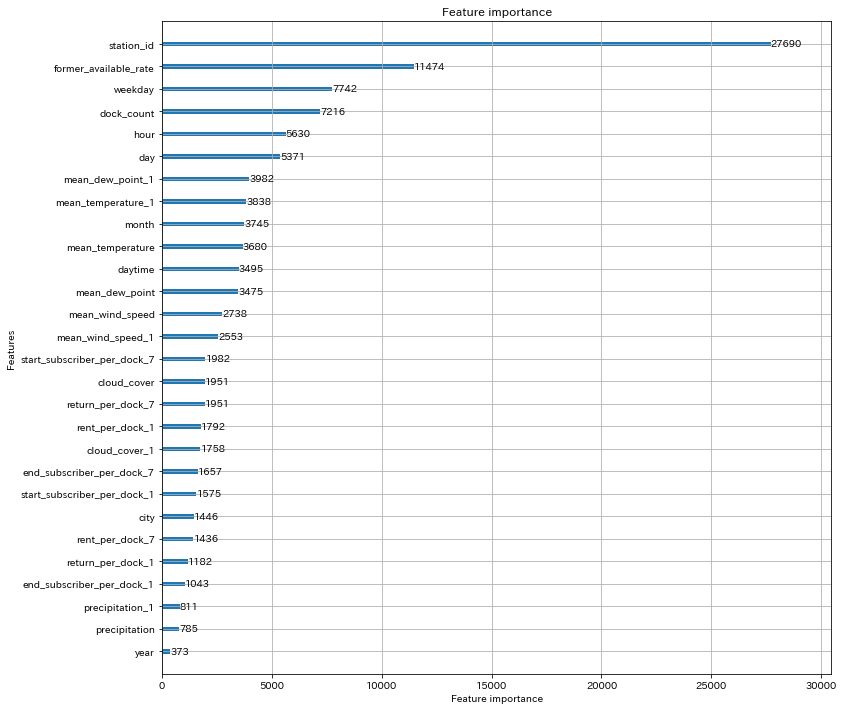

In [62]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, importance_type='split', figsize=(12,12))
plt.show()

## 予測結果の提出
- 5つの予測値のアンサンブル

In [63]:
test_pred = pd.DataFrame(pred_list).T
test_pred.columns = ['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']
test_pred['mean'] = (test_pred['pred_1'] + test_pred['pred_2'] + test_pred['pred_3'] + test_pred['pred_4'] + test_pred['pred_5']) / 5
test_pred_ensamble = pd.DataFrame(test_pred['mean'])
test_index = test_df.reset_index()['id']
test_index = pd.DataFrame(test_index)
submit = pd.concat([test_index, test_pred_ensamble], axis=1)
submit['mean'] = submit['mean'].apply(lambda x: 0 if x < 0 else x)
submit.to_csv('submit.csv', index=False, header=None)

In [64]:
submit

,id,mean
0,8761,11.11
1,8762,11.11
2,8763,11.11
3,8764,11.13
4,8765,10.79
...,...,...
193195,1226347,7.54
193196,1226348,7.99
193197,1226349,8.10
193198,1226350,8.20
